In [6]:
from collections import defaultdict
from tqdm import tqdm
from typing import Callable
import datasets
import librosa

from IPython.display import Audio
from matplotlib import pyplot as plt


TARGET_SR = 22050

huggingface_dataset = datasets.load_dataset('librispeech_asr', 'clean', split='train.100')

def populate_speaker_hist(huggingface_dataset, filter: Callable = lambda x: True):
    """

    :param huggingface_dataset:
    :param filter: a function that takes a huggingface_dataset example and returns a bool
        indicating whether it should be included in the histogram
    :return:
    """
    hist = defaultdict(lambda: 0)
    for example in tqdm(huggingface_dataset):
        if filter(example):
            speaker_id = example['speaker_id']
            hist[speaker_id] += 1
    return hist

def populate_utt_length_hist(huggingface_dataset, filter: Callable = lambda x: True):
    hist = defaultdict(lambda: 0)
    for example in tqdm(huggingface_dataset):
        if filter(example):
            processed_text = example['text']
            n_words = len(processed_text.split(" "))
            hist[n_words] += 1
    return hist


def render_example(example):
    wav = example['audio']['array']
    native_sr = example['audio']['sampling_rate']
    resampled = librosa.resample(wav, orig_sr=native_sr, target_sr=TARGET_SR)
    return Audio(resampled, rate=TARGET_SR)

def get_unique_words(huggingface_dataset, filter: Callable = lambda x: True):
    words = set()
    for example in tqdm(huggingface_dataset):
        if filter(example):
            processed_text = example['text']
            words |= set(processed_text.split(" "))
    return words

Reusing dataset librispeech_asr (/home/ani.vegesana.backup/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/1f4602f6b5fed8d3ab3e3382783173f2e12d9877e98775e34d7780881175096c)


In [7]:
s = get_unique_words(huggingface_dataset)
len(s)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28539/28539 [02:03<00:00, 231.58it/s]


33798

In [13]:
def plot_utt_length_hist(hist):
    utt_lens = []
    for k, v in hist.items():
        utt_lens.extend([k]*v)
    plt.hist(utt_lens)
    
# def plot_speaker_hist(hist):
#     plt.bar(hist.keys(), hist.values())

In [18]:
def populate_audio_len_dist(huggingface_dataset, filter: Callable = lambda x: True):
    dist = []
    for example in tqdm(huggingface_dataset):
        if filter(example):
            arr = example['audio']['array']
            sr = example['audio']['sampling_rate']
            n_secs = len(arr)/sr
            dist.append(n_secs)
    return dist

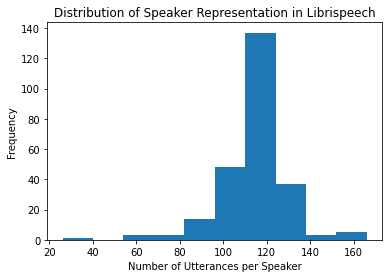

In [16]:
speaker_hist = populate_speaker_hist(huggingface_dataset)
plt.hist(speaker_hist.values())
plt.title('Speaker Representation in Librispeech')
plt.xlabel('Number of Utterances by a Speaker')
plt.ylabel('Frequency')
plt.show()

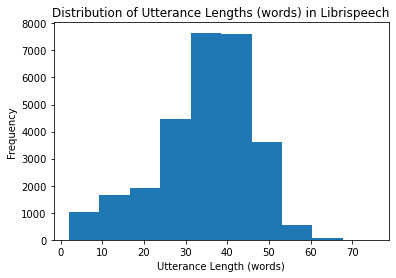

In [21]:
utt_length_hist = populate_utt_length_hist(huggingface_dataset)
plot_utt_length_hist(utt_length_hist)
plt.title('Distribution of Utterance Lengths (words) in Librispeech')
plt.xlabel('Utterance Length (words)')
plt.ylabel('Frequency')
plt.show()

In [19]:
audio_len_dist = populate_audio_len_dist(huggingface_dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28539/28539 [02:00<00:00, 237.00it/s]


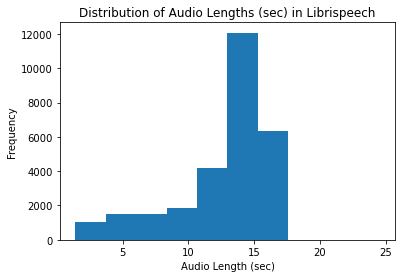

In [22]:
plt.hist(audio_len_dist)
plt.title('Distribution of Audio Lengths (sec) in Librispeech')
plt.xlabel('Audio Length (sec)')
plt.ylabel('Frequency')
plt.show()

In [23]:
num_utterances = sum(utt_length_hist.values())
num_utterances

28539

In [24]:
speakers_with_good_rep = [speaker_id for speaker_id, rep in speaker_hist.items() if rep > 140]

In [25]:
speakers_with_good_rep

[2989, 4014, 730, 8063, 211]

In [26]:
dataset_2989 = huggingface_dataset.filter(lambda sample: sample['speaker_id'] == 2989)
dataset_4014 = huggingface_dataset.filter(lambda sample: sample['speaker_id'] == 4014)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [02:32<00:00,  5.25s/ba]


In [29]:
render_example(dataset_2989[1])

In [28]:
render_example(dataset_4014[0])

In [33]:
import sys
sys.path.insert(0, 'asr')
import dataset
adapter = dataset.LibriDatasetAdapter(huggingface_dataset)

Loading cached processed dataset at /home/ani.vegesana.backup/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/1f4602f6b5fed8d3ab3e3382783173f2e12d9877e98775e34d7780881175096c/cache-a795eaaac6783cf6.arrow
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28456/28456 [00:38<00:00, 731.85ex/s]


In [35]:
recover_id = (i for i in range(8000000) if adapter[i].speaker_idx == 2989)
next(recover_id)
next(recover_id)

KeyboardInterrupt: 

In [ ]:
recover_id = (i for i in range(8000000) if adapter[i].speaker_idx == 4014)
next(recover_id)